In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pickle

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

import warnings
warnings.simplefilter("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [89]:
df = pd.read_csv('dataset.csv', sep=";")
df.head()

ID  booking occupation_id_desc had_a_flight_in_last_cruise  \
0   1      NaN                NaN                         NaN   
1   2      NaN                NaN                       False   
2   3      NaN                NaN                         NaN   
3   4      NaN                NaN                       False   
4   5      NaN                NaN                         NaN   

  booked_country_aggregation  AGE  LOYALTY_TOTAL_SCORE  NUMBER_OF_CRUISES  \
0                     FRANCE   48                    0                  0   
1                  ARGENTINA   76                 5842                  7   
2                      ITALY   42                    0                  0   
3                    GERMANY   33                    0                  1   
4                      ITALY   44                    0                  0   

  rfm_segment  is_loyalty  ...  flag_opt_cxl_last3y  flag_bkd_cxl_last_month  \
0    PROSPECT       False  ...                  1.0                      0.0   
1      0 HIGH        True  ...                  NaN                      NaN   
2    PROSPECT        True  ...                  NaN                      NaN   
3        LOST       False  ...                  NaN                      NaN   
4    PROSPECT        True  ...                  1.0                      0.0   

  flag_opt_cxl_last_month num_cruises_last3y total_gross_cru_rev_eur_mean  \
0                     0.0                NaN                          NaN   
1                     NaN                6.0                  1197.578263   
2                     NaN                NaN                          NaN   
3                     NaN                NaN                          NaN   
4                     0.0                NaN                          NaN   

  total_gross_obr_rev_eur_mean sent_last_month open_last_month  \
0                          NaN             NaN             NaN   
1                   108.833333             NaN             NaN   
2                          NaN             2.0             2.0   
3                          NaN             NaN             NaN   
4                          NaN             1.0             0.0   

   click_last_month         source_desc  
0               NaN  RESERVATION SYSTEM  
1               NaN                 NaN  
2               0.0                 WEB  
3               NaN                 NaN  
4               0.0                 WEB  

[5 rows x 37 columns]

In [90]:
df.isnull().sum()

ID                                   0
booking                          10000
occupation_id_desc               97272
had_a_flight_in_last_cruise      31934
booked_country_aggregation           0
AGE                                  0
LOYALTY_TOTAL_SCORE                  0
NUMBER_OF_CRUISES                    0
rfm_segment                          0
is_loyalty                           0
pcc_flag                             0
flag_app                           101
opener_segment                   63964
privacy_channel_email_date       46151
privacy_channel_phone_date       46311
privacy_channel_post_date        46840
privacy_send_material_date       35622
loyalty_subscribe_date           65402
days_after_cruise_end            40165
BKG_Channel                      33578
last_cruise_program_desc         32217
last_cruise_duration             32116
last_cruise_bkg_anticipation       100
last_paid_cabin_meta_cat_code    32233
last_nps_segment                 92871
last_pax_type            

In [91]:
logging.info("plotting distribution of some columns...")

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("AGE", "days_after_cruise_end", "sent_last_month", "NUMBER_OF_CRUISES"))

fig.add_trace(
    go.Histogram(x=df["AGE"]),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df["days_after_cruise_end"]),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(x=df["sent_last_month"]),
    row=2, col=1
)

fig.add_trace(
    go.Histogram(x=df["NUMBER_OF_CRUISES"]),
    row=2, col=2
)


fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

INFO:root:plotting distribution of some columns...


In [92]:
df.drop(columns=[
                  "occupation_id_desc", "privacy_channel_email_date", "privacy_channel_phone_date", "privacy_channel_post_date",
                  "privacy_send_material_date", "loyalty_subscribe_date", "last_nps_segment", "flag_bkd_cxl_last3y",
                  "flag_bkd_cxl_last_month", "flag_opt_cxl_last3y", "flag_opt_cxl_last_month", "num_cruises_last3y",
                  "total_gross_cru_rev_eur_mean", "total_gross_obr_rev_eur_mean", "source_desc", "last_pax_type"], 
                   axis=1, inplace=True) 
                    
logging.info('the desired columns are dropped successfully')

INFO:root:the desired columns are dropped successfully


In [93]:
df_test = df[df["booking"].isnull()].reset_index(drop=True)
df_model = df[df["booking"].notnull()].reset_index(drop=True)

In [94]:
### fillna with mode and median

mode_pcc_flag = df_model["flag_app"].mode().values[0]
df_model["flag_app"].fillna(mode_pcc_flag, inplace=True)

mode_last_cruise_duration = df_model["last_cruise_duration"].mode().values[0]
df_model["last_cruise_duration"].fillna(mode_last_cruise_duration, inplace=True)

median_last_anticipation = df_model["last_cruise_bkg_anticipation"].median()
df_model["last_cruise_bkg_anticipation"].fillna(median_last_anticipation, inplace=True)

logging.info('the NULL values are fullfilled with mode and median')

INFO:root:the NULL values are fullfilled with mode and median


INFO:root:ploting the correlation between numerical columns...


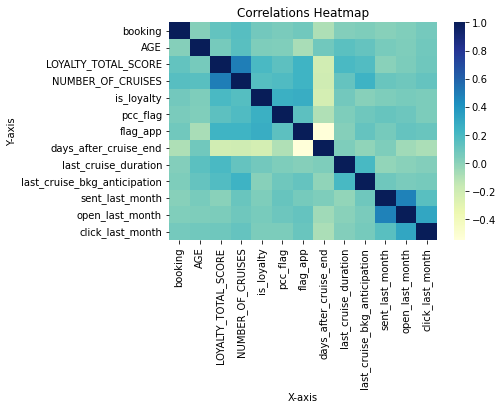

In [95]:
### the correlation between numerical features

logging.info('ploting the correlation between numerical columns...')

df_corr = df_model.drop(columns=["ID"]).corr()  ## TODO: heatmap plotly

sns.heatmap(df_corr, cmap='YlGnBu')  # annot=True displays the data values on the heatmap
plt.title('Correlations Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [96]:
## TODO: subplot the distribution with plotly

In [97]:
### segmenting the 'days_after_cruise_end' to a categorical column.

logging.info('categorizing the "days_after_cruise_end" ...')

bins = [-np.inf, 90, 730, 1460, np.inf] ## based on their distribution
names = ['less_than_3month', 'between_3month_and_2year','between_2year_and_4year', 'more_than_4year']

df_model['period_after_cruise_end'] = pd.cut(df_model['days_after_cruise_end'], bins, labels=names)

df_model.drop(columns=["days_after_cruise_end"], axis=1, inplace=True)

INFO:root:categorizing the "days_after_cruise_end" ...


In [98]:
### segmenting the 'click_last_month', 'open_last_month', 'sent_last_month' to categorical columns.

logging.info('categorizing the following columns: "click_last_month", "open_last_month", and "sent_last_month"  ...')

bins2 = [-np.inf, 0, 4, np.inf] ## based on their distribution
names2 = ['0', 'between_0_and_4','more_than_4']

df_model['category_click_last_month'] = pd.cut(df_model['click_last_month'], bins2, labels=names2)
df_model['category_open_last_month'] = pd.cut(df_model['open_last_month'], bins2, labels=names2)
df_model['category_sent_last_month'] = pd.cut(df_model['sent_last_month'], bins2, labels=names2)

df_model.drop(columns=["click_last_month", "open_last_month", "sent_last_month"], axis=1, inplace=True)

INFO:root:categorizing the following columns: "click_last_month", "open_last_month", and "sent_last_month"  ...


In [99]:
### encoding and scaling of categorical and numerical features

logging.info('performing encoding and scaling ...')

categorical_columns = ["had_a_flight_in_last_cruise", "BKG_Channel", "rfm_segment",  "period_after_cruise_end",
                        "last_paid_cabin_meta_cat_code", "category_open_last_month", 
                        "category_sent_last_month"
                        ] #,"last_cruise_program_desc", ,"category_click_last_month", "opener_segment"

numerical_columns = ["AGE", "LOYALTY_TOTAL_SCORE", "is_loyalty", "NUMBER_OF_CRUISES", "pcc_flag", "flag_app", 
                     "last_cruise_duration", "last_cruise_bkg_anticipation"
                      ] #

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df_model[categorical_columns])
encoded_df = encoder.transform(df_model[categorical_columns]).toarray()
encoded_df = pd.DataFrame(encoded_df, columns=encoder.get_feature_names(categorical_columns))



scaler = MinMaxScaler(feature_range=(0,1))

        # fit and transform the numerical columns of the dataframe
scaled_df = scaler.fit_transform(df_model[numerical_columns])

        # create a new dataframe with the scaled values
scaled_df = pd.DataFrame(scaled_df, columns=numerical_columns)

INFO:root:performing encoding and scaling ...


In [100]:
X = pd.concat([encoded_df, scaled_df], axis=1) ## merging the encoded categorical and numerical features

target_column = "booking"
y = df_model[target_column]

In [101]:
# split data into train and test sets
seed = 42
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [102]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=seed)
X_res, y_res = sm.fit_resample(X_train, y_train)

logging.info('Resampled dataset shape %s' % len(y_res))

INFO:root:Resampled dataset shape 151244


In [103]:
def calculate_class_weights(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0 * class_count)
        class_weights[class_label] = class_weight

    return class_weights

# Assuming 'y' contains the class labels (0s and 1s) for the binary classification problem
class_weights = calculate_class_weights(y)

logging.info(f"Class weights: {class_weights}")

INFO:root:Class weights: {0.0: 0.5058851965104776, 1.0: 42.97946513849092}


In [104]:
clf = RandomForestClassifier(max_depth=3, random_state=seed, class_weight=class_weights) # ,  

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

logging.info("fitting and prediction is done")

INFO:root:fitting and prediction is done


INFO:root:calculating and displaying confusion matrix


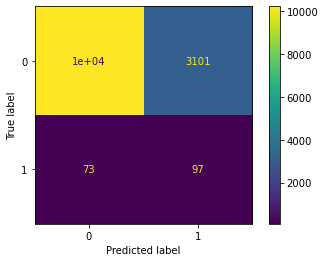

In [105]:
logging.info("calculating and displaying confusion matrix")

cm = confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [106]:
logging.info(f"**** RECALL:  {recall_score(y_test, y_pred, average='weighted')}")
logging.info(f"**** PRECISION: {precision_score(y_test, y_pred, average='weighted')}")
logging.info(f"**** F1_SCORE: {f1_score(y_test, y_pred, average='weighted')}")

INFO:root:**** RECALL:  0.7648888888888888
INFO:root:**** PRECISION: 0.9807925875175901
INFO:root:**** F1_SCORE: 0.8555146454306939


In [ ]:
# filename = 'model_rfc.pkl'
# pickle.dump(clf, open(filename, 'wb'))